# Data Loading and Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import pickle
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier

In [3]:
data_dir = './data/'

In [4]:
results_dir = './data/results/'

In [5]:
models_dir = './models/'

In [6]:
model_name = 'long_short_term_memory_classification'

In [7]:
classification_data = pd.read_csv(data_dir+'classification_data.csv', index_col=[0])

# LSTM (Classification)

## Functions

In [1]:
def build_model_LSTM(hid_layer_nums = 1, units=100, input_shape=(1, 19)):
    # LSTM model
    clf = Sequential()

    # First LSTM layer with Dropout regularisation
    clf.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    clf.add(Activation("relu"))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.2))

    # Hidden LSTM layers
    for hid_layer_num in range(hid_layer_nums-1):
        clf.add(LSTM(units=units, return_sequences=True))
        clf.add(Activation("relu"))
        clf.add(BatchNormalization())
        clf.add(Dropout(0.2))

    # Last LSTM layer
    clf.add(LSTM(units=units))
    clf.add(Activation("relu"))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.2))

    # The output layer
    clf.add(Dense(units=2, activation='sigmoid'))

    return clf

In [9]:
def obtain_metrics(y, predictions):
    matrix = classification_report(y, predictions, output_dict=True)
    # accuracy 
    accuracy = round(accuracy_score(y, predictions), 3)
    # AUROC
    fpr, tpr, threshold = roc_curve(y, predictions)
    auroc = round(auc(fpr, tpr), 3)
    # precision
    prec_0 = round(matrix['0']['precision'], 3)
    prec_1 = round(matrix['1']['precision'], 3)
    prec = recall_score(y, predictions)
    # recall
    rec_0 = round(matrix['0']['recall'], 3)
    rec_1 = round(matrix['1']['recall'], 3)
    rec = recall_score(y, predictions)
    # f-1 score
    f1_0 = round(matrix['0']['f1-score'], 3)
    f1_1 = round(matrix['1']['f1-score'], 3)
    f1 = (f1_0 + f1_1)/2
    return accuracy, auroc, prec_0, prec_1, prec, rec_0, rec_1, rec, f1_0, f1_1, f1

## Implementation

In [10]:
classification_data

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,1,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8120,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,brown,1,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,unknown,smooth,silky,white,1,evanescent,white,several,leaves


In [11]:
classification_data.shape

(8124, 20)

In [12]:
dep_var = 'edible'

In [13]:
X = classification_data.iloc[:,classification_data.columns != dep_var]

In [14]:
y = classification_data[dep_var]

In [15]:
y

0       poisonous
1          edible
2          edible
3       poisonous
4          edible
          ...    
8119       edible
8120       edible
8121       edible
8122    poisonous
8123       edible
Name: edible, Length: 8124, dtype: object

In [16]:
# Random 6-digit seed
test_seed = 513370

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=test_seed, stratify=y)

Initialise the dataframe that holds the results of the datasets

In [18]:
columns = ['task', 'model', 'seed', 'split', 'optimizer', 'hidden_layers_no', 'units', 'train_accuracy', 'valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1_score', 'valid_auroc']
long_short_term_memory_classification_results_df = pd.DataFrame(columns=columns)
df_rows = 0

In [19]:
# 5 random 6 digit numbers
seeds = [660108, 720389, 193768, 586930, 327407]

Now we need to prepare our data and the cross-validation process so that we can start training.

In [20]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
optimizers = {'adam': adam}

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline

for seed in seeds:
    print(f'Starting training for seed {seed}')
    # assign the tuned parameters
    split = 0
    num_of_hidden_layers = [5, 6, 7]
    num_of_units = [32, 64, 128, 256] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
    for train_index, valid_index in KFold(n_splits=5, shuffle=False).split(X_train):
        # Data Split
        split += 1
        X_train_curr_split = X_train.iloc[train_index]
        X_valid_curr_split = X_train.iloc[valid_index]
        y_train_curr_split = y_train.iloc[train_index]
        y_valid_curr_split = y_train.iloc[valid_index]
        
        # Encode the data
        enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
        X_train_curr_split = enc.fit_transform(X_train_curr_split)
        X_valid_curr_split = enc.transform(X_valid_curr_split)
        
#         # Scale the data        
#         scaler = preprocessing.StandardScaler()
#         X_train_curr_split = scaler.fit_transform(X_train_curr_split)
#         X_valid_curr_split = scaler.transform(X_valid_curr_split)
        
        # Reshape the data
        X_train_curr_split_transformed = X_train_curr_split.reshape(X_train_curr_split.shape[0], 1, X_train_curr_split.shape[1])
        X_valid_curr_split_transformed = X_valid_curr_split.reshape(X_valid_curr_split.shape[0], 1, X_valid_curr_split.shape[1])

        # as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
        encoder_dict = {'edible': 1,
                        'poisonous': 0}
        
        # transform the output into the right format
        y_train_curr_split = y_train_curr_split.replace(encoder_dict).values
        y_valid_curr_split = y_valid_curr_split.replace(encoder_dict).values
        y_train_curr_split_transformed = to_categorical(y_train_curr_split, 2)
        y_valid_curr_split_transformed = to_categorical(y_valid_curr_split, 2)

        
        for hidden_layers in num_of_hidden_layers:
            for units in num_of_units:
                model = build_model_LSTM(hid_layer_nums = hidden_layers, units=units)
                model.compile(optimizer=optimizers['adam'], loss='binary_crossentropy', metrics=['accuracy' , 
                                                                                                 keras.metrics.Precision(), 
                                                                                                 keras.metrics.Recall()])
                
                # train the model
                model.fit(X_train_curr_split_transformed, y_train_curr_split_transformed, epochs=10, batch_size=32, verbose=1,
                          validation_data=(X_valid_curr_split_transformed, y_valid_curr_split_transformed)) 
                
                # Obtain metric scores
                train_predictions = np.argmax(model.predict(X_train_curr_split_transformed), axis=1)
                valid_predictions = np.argmax(model.predict(X_valid_curr_split_transformed), axis=1)
                
                train_accuracy, _, _, _, _, _, _, _, _, _, _ = obtain_metrics(y_train_curr_split, train_predictions)
                valid_accuracy, valid_auroc, _, _, valid_prec_score, _, _, valid_rec_score, _, _, valid_f1_score = obtain_metrics(y_valid_curr_split, valid_predictions)
                  
                long_short_term_memory_classification_results_df.loc[df_rows] = ['classification', 
                                                                                 'LSTM', 
                                                                                 seed,
                                                                                 split,
                                                                                 'adam',
                                                                                 hidden_layers,
                                                                                 units,
                                                                                 train_accuracy,
                                                                                 valid_accuracy,
                                                                                 valid_prec_score,
                                                                                 valid_rec_score,
                                                                                 valid_f1_score,
                                                                                 valid_auroc]
                # increment the rows variable
                df_rows +=1
    print(f'Done training for seed {seed}')     

## Functions

In [21]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [25]:
long_short_term_memory_classification_results_df

,task,model,seed,split,optimizer,hidden_layers_no,units,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,classification,LSTM,660108,1,adam,5,32,0.939,0.920,0.968300,0.968300,0.9190,0.916
1,classification,LSTM,660108,1,adam,5,64,0.997,0.995,0.997118,0.997118,0.9955,0.995
2,classification,LSTM,660108,1,adam,5,128,1.000,1.000,1.000000,1.000000,1.0000,1.000
3,classification,LSTM,660108,1,adam,5,256,1.000,1.000,1.000000,1.000000,1.0000,1.000
4,classification,LSTM,660108,1,adam,6,32,0.988,0.980,0.988473,0.988473,0.9795,0.979
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,classification,LSTM,327407,5,adam,6,256,1.000,1.000,1.000000,1.000000,1.0000,1.000
296,classification,LSTM,327407,5,adam,7,32,0.933,0.941,0.991004,0.991004,0.9405,0.939
297,classification,LSTM,327407,5,adam,7,64,0.994,0.988,0.997001,0.997001,0.9885,0.988
298,classification,LSTM,327407,5,adam,7,128,0.999,0.997,0.994003,0.994003,0.9970,0.997


Aggregate the values so that we average the results for each random seed

In [26]:
grouped_long_short_term_memory_classification_results_df = group_seeded_data(long_short_term_memory_classification_results_df, 
                                                                            ['optimizer', 'hidden_layers_no','units'],
                                                                            )

In [27]:
grouped_long_short_term_memory_classification_results_df.to_csv(results_dir + 'grouped_long_short_term_memory_classification_results_df.csv')

In [28]:
grouped_long_short_term_memory_classification_results_df

,optimizer,hidden_layers_no,units,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,adam,5,32,0.98440,0.98128,0.985656,0.985656,0.98116,0.98108
1,adam,5,64,0.99876,0.99796,0.998877,0.998877,0.99808,0.99800
2,adam,5,128,0.99992,0.99972,1.000000,1.000000,0.99974,0.99972
3,adam,5,256,0.99992,0.99980,0.999939,0.999939,0.99980,0.99980
4,adam,6,32,0.97492,0.97260,0.976132,0.976132,0.97258,0.97252
5,adam,6,64,0.99688,0.99596,0.995519,0.995519,0.99594,0.99596
6,adam,6,128,0.99984,0.99952,0.999706,0.999706,0.99958,0.99956
7,adam,6,256,0.99996,0.99996,1.000000,1.000000,0.99996,0.99996
8,adam,7,32,0.95192,0.95116,0.958313,0.958313,0.95106,0.95092
9,adam,7,64,0.99456,0.99308,0.992176,0.992176,0.99320,0.99320


## Functions

In [29]:
def plot_line(data, x_column='units', groupby_column = 'hidden_layers_no', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    grouped_data = data.groupby([x_column, groupby_column]).agg(acc=(acc, 'mean')).reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.set_xticks(grouped_data[x_column].unique())  # Set label locations.
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [46]:
def plot_history(history, metric='loss'):
    # summarize history for loss
    plt.plot(history[f'{metric}'], label='train')
    plt.plot(history[f'val_{metric}'], label='test')
    plt.title(f'model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [31]:
def plot_conf_matrix(y_test, test_predictions, tick_size=12):
    conf_matrix = confusion_matrix(y_test, test_predictions)
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(conf_matrix, annot=True,linewidths=0.5,linecolor="red", fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size, labelrotation=90)
    plt.show()

## Overal results demonstration

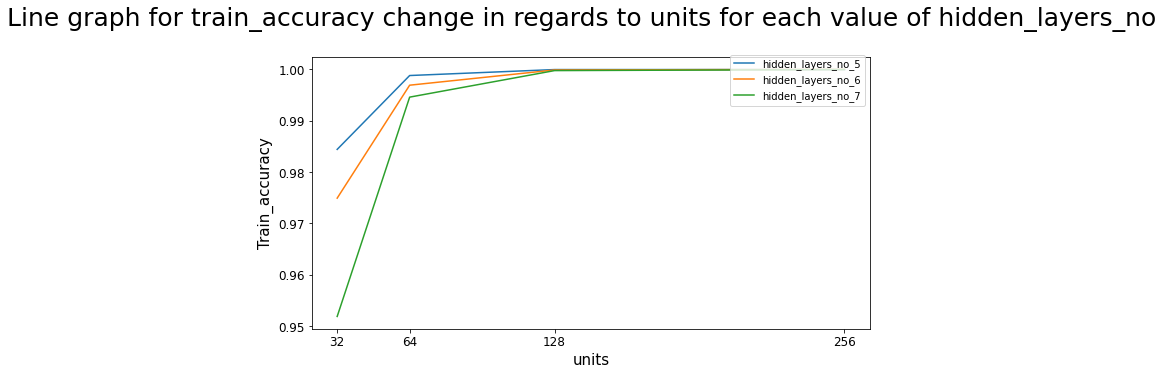

In [32]:
plot_line(grouped_long_short_term_memory_classification_results_df, acc='train_accuracy')

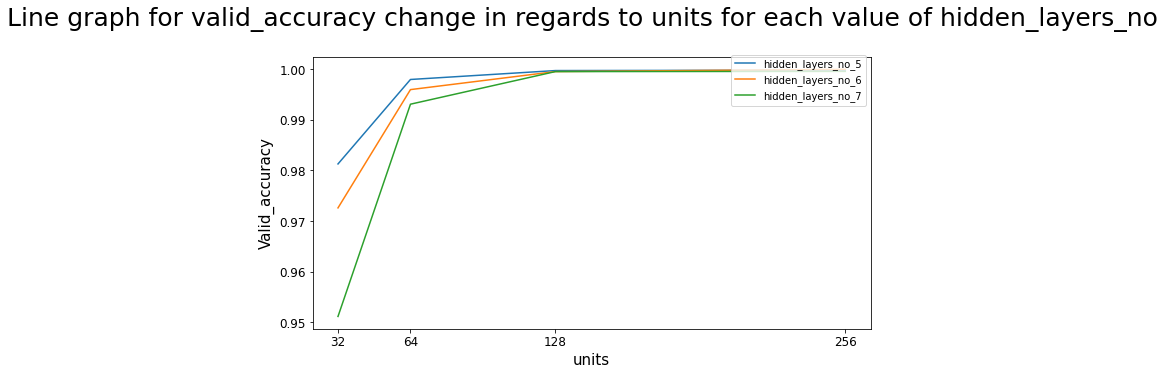

In [33]:
plot_line(grouped_long_short_term_memory_classification_results_df, acc='valid_accuracy')

From the two line graphs available above, it can be seen that neither of the models overfit on the training data. Also as the number of units in the hidden layers increase, the accuracy also does. In the beggining the model with 5 hidden layers does the best.

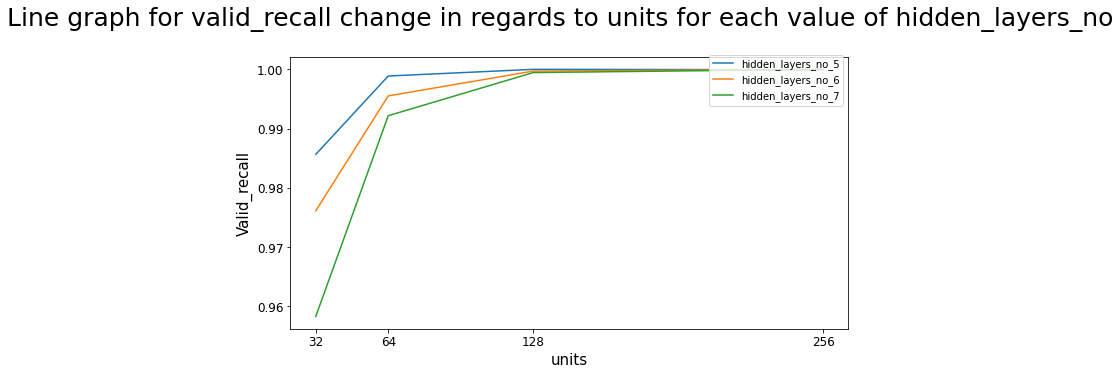

In [34]:
plot_line(grouped_long_short_term_memory_classification_results_df, acc='valid_recall')

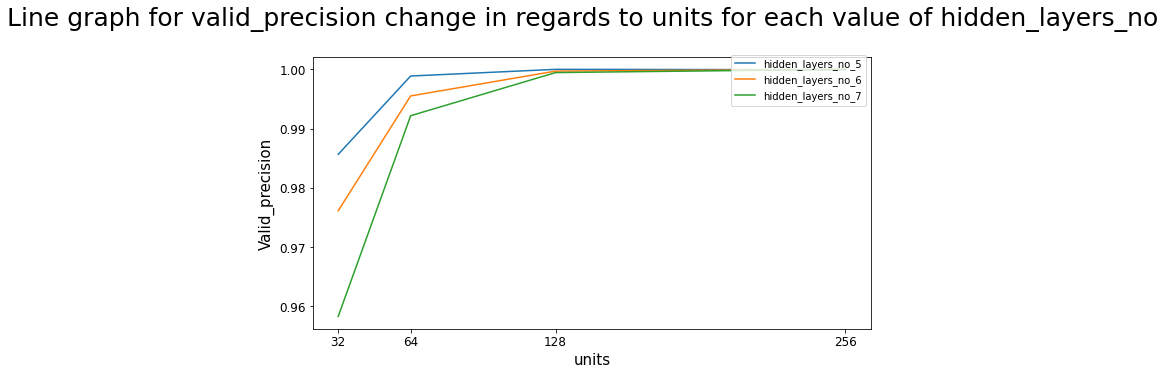

In [35]:
plot_line(grouped_long_short_term_memory_classification_results_df, acc='valid_precision')

It seems that recall and precision metric values increase accordingly. Again the metric that we are going to use, to determine the predictive capabilities of our model is going to be precision as it is important not to classify a posinous mushroom (0) as an edible one. 

In [36]:
grouped_long_short_term_memory_classification_results_df[grouped_long_short_term_memory_classification_results_df['valid_precision'] == grouped_long_short_term_memory_classification_results_df['valid_precision'].max()]

,optimizer,hidden_layers_no,units,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
2,adam,5,128,0.99992,0.99972,1.0,1.0,0.99974,0.99972
7,adam,6,256,0.99996,0.99996,1.0,1.0,0.99996,0.99996
11,adam,7,256,0.99992,0.99956,1.0,1.0,0.99960,0.99956


In [63]:
model = build_model_LSTM(hid_layer_nums = 6, units=256)

model.compile(optimizer=optimizers['adam'], loss='binary_crossentropy', metrics=['accuracy' , 
                                                                                 keras.metrics.Precision(), 
                                                                                 keras.metrics.Recall()])


In [38]:
# Encode the data
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)

# # Scale the data        
# scaler = preprocessing.StandardScaler()
# X_train_enc = scaler.fit_transform(X_train_enc)
# X_test_enc = scaler.transform(X_test_enc)

# Reshape the data
X_train_enc_transformed = X_train_enc.reshape(X_train_enc.shape[0], 1, X_train_enc.shape[1])
X_test_enc_transformed = X_test_enc.reshape(X_test_enc.shape[0], 1, X_test_enc.shape[1])

# as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
encoder_dict = {'edible': 1,
                'poisonous': 0}

# transform the output into the right format
y_train_enc = y_train.replace(encoder_dict).values
y_test_enc = y_test.replace(encoder_dict).values
y_train_enc_transformed = to_categorical(y_train_enc, 2)
y_test_enc_transformed = to_categorical(y_test_enc, 2)


In [39]:
# as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
encoder_dict = {'edible': 1,
                'poisonous': 0}

# transform the output into the right format
y_train_enc = y_train.replace(encoder_dict).values
y_test_enc = y_test.replace(encoder_dict).values
y_train_enc_transformed = to_categorical(y_train_enc, 2)
y_test_enc_transformed = to_categorical(y_test_enc, 2)


In [64]:
# train the model
history = model.fit(X_train_enc_transformed, y_train_enc_transformed, epochs=10, batch_size=32, verbose=1,
                    validation_data=(X_test_enc_transformed, y_test_enc_transformed)) 

Epoch 1/10
204/204 [==============================] - 25s 54ms/step - loss: 0.2456 - accuracy: 0.9029 - precision_1: 0.8945 - recall_1: 0.8924 - val_loss: 0.6922 - val_accuracy: 0.5182 - val_precision_1: 0.5182 - val_recall_1: 0.5182
Epoch 2/10
204/204 [==============================] - 8s 39ms/step - loss: 0.0871 - accuracy: 0.9697 - precision_1: 0.9691 - recall_1: 0.9695 - val_loss: 0.5668 - val_accuracy: 0.5446 - val_precision_1: 0.5795 - val_recall_1: 0.5182
Epoch 3/10
204/204 [==============================] - 8s 38ms/step - loss: 0.0560 - accuracy: 0.9809 - precision_1: 0.9794 - recall_1: 0.9800 - val_loss: 0.0040 - val_accuracy: 0.9994 - val_precision_1: 0.9988 - val_recall_1: 0.9994
Epoch 4/10
204/204 [==============================] - 8s 41ms/step - loss: 0.0358 - accuracy: 0.9882 - precision_1: 0.9891 - recall_1: 0.9869 - val_loss: 0.0011 - val_accuracy: 0.9994 - val_precision_1: 0.9994 - val_recall_1: 0.9994
Epoch 5/10
204/204 [==============================] - 8s 40ms/step 

In [41]:
hist_dict = history.history

### History plots

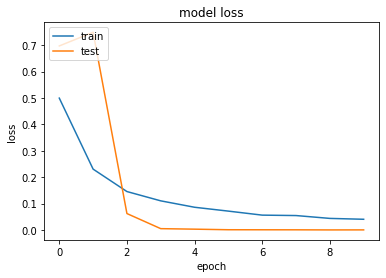

In [47]:
plot_history(hist_dict, metric='loss')

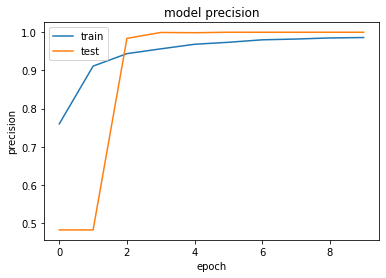

In [48]:
plot_history(hist_dict, metric='precision')

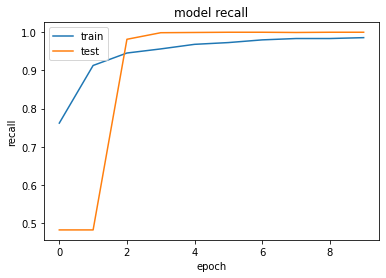

In [49]:
plot_history(hist_dict, metric='recall')

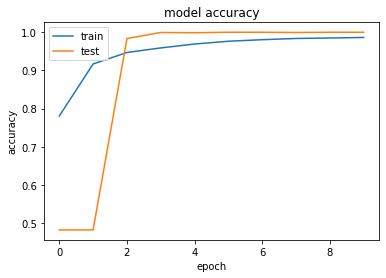

In [50]:
plot_history(hist_dict, metric='accuracy')

In [51]:
# Obtain metric scores
train_predictions = np.argmax(model.predict(X_train_enc_transformed), axis=1)
test_predictions = np.argmax(model.predict(X_test_enc_transformed), axis=1)

train_accuracy, _, _, _, _, _, _, _, _, _, _ = obtain_metrics(y_train_enc, train_predictions)
test_accuracy, test_auroc, _, _, test_prec_score, _, _, test_rec_score, _, _, test_f1_score = obtain_metrics(y_test_enc, test_predictions)


### Results on test set

In [52]:
print(f"The precision score on the test set for the best model is {round(test_prec_score, 3)} \n")

The precision score on the test set for the best model is 1.0 



In [53]:
print(f"The recall score on the test set for the best model is {round(test_rec_score, 3)} \n")

The recall score on the test set for the best model is 1.0 



In [54]:
print(f"The f1-score on the test set for the best model is {round(test_f1_score, 3)} \n")

The f1-score on the test set for the best model is 1.0 



In [55]:
print(f"The auroc score on the test set for the best model is {round(test_auroc, 3)} \n")

The auroc score on the test set for the best model is 1.0 



In [56]:
print(f"The accuracy on the test set for the best model is {round(test_accuracy, 3)} \n")

The accuracy on the test set for the best model is 1.0 



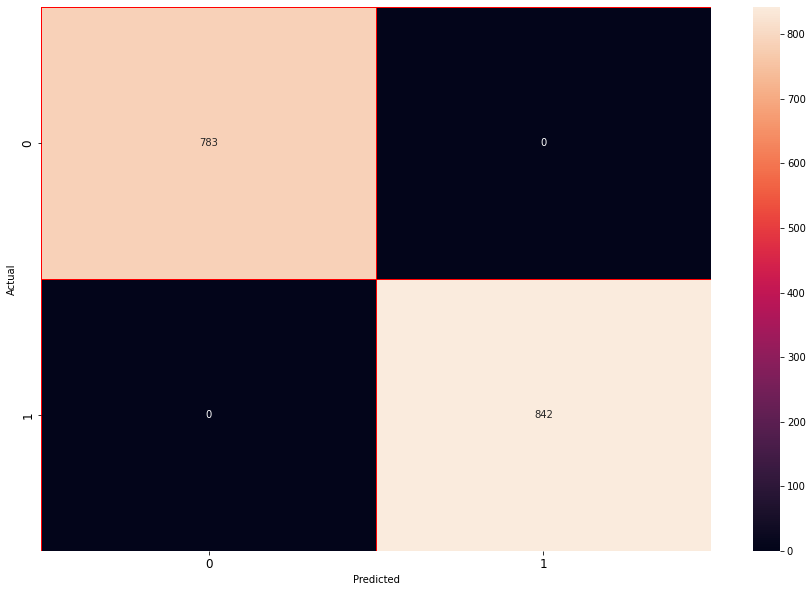

In [57]:
plot_conf_matrix(y_test_enc, test_predictions)

Save the model on disc

In [58]:
model.save_weights(models_dir+model_name+'.h5')

Load the model from disk

In [59]:
model = build_model_LSTM(hid_layer_nums = 6, units=256)
model.load_weights(models_dir+model_name+'.h5')

In [ ]:
model.summary()